# Experiment POC OBI
> Can we get better by training on our assumptions?

In [ ]:
# default_exp poc_online_bayesian_inference

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
import wandb
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_challenges import (
    AdditiveGaussianNoise,
    NamedDataset,
    create_repeated_MNIST_dataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.experiment_logging import asclassdict, init_wandb, log2wandb
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory
from batchbald_redux.online_bayesian_inference import evaluate_online_bayesian_inference

In [ ]:
# exports

# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedBayesianModel

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt

(array([55951.,  1227.,   635.,   386.,   241.,   206.,   130.,   117.,
          118.,    74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

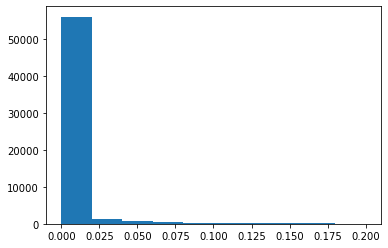

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.2])

In [ ]:
60000 - len(torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy())

5678

In [ ]:
# exports

# Rerun from 2022/04/15

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    17776,
    36852,
    26891,
    17001,
    44414,
    23050,
    30884,
    41516,
    8897,
    34608,
    11721,
    13127,
    9870,
    39700,
    13985,
    9608,
    17808,
    23028,
    3494,
    10210,
    42384,
    31742,
    17100,
    46530,
    26733,
    4762,
    14113,
    20798,
    28388,
    42973,
    37347,
    55042,
    41295,
    28310,
    19280,
    18501,
    274,
    11208,
    13335,
    24440,
    49493,
    58129,
    56210,
    40766,
    13318,
    50040,
    18408,
    7255,
    15494,
    7168,
    9472,
    14845,
    14096,
    26072,
    35944,
    34836,
    12655,
    991,
    38577,
    47322,
    45212,
    16286,
    5308,
    38182,
    31624,
    12702,
    30861,
    46320,
    36408,
    49841,
    33426,
    57527,
    3273,
    24740,
    39627,
    22199,
    19362,
    42136,
    41965,
    43095,
]

training_set_90[:20] = [51348,
 49110,
 8222,
 28130,
 13484,
 47685,
 3938,
 59930,
 49196,
 19427,
 4601,
 49922,
 45635,
 35684,
 3579,
 7621,
 8465,
 33959,
 27521,
 27015]


@dataclass
class Experiment:
    seed: int = 1337
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    min_samples_per_epoch: int = 1024
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    max_obi_steps: int = 10
    num_samples_list: int = (100, 1000, 10000)
    up_factor: int = 2
    num_trials: int = 5
    acquisition_size: int = 5

    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )
        
        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire_base_indices(training_set_90[:20])

        active_learning_data_validation_set = ActiveLearningData(train_dataset)
        active_learning_data_validation_set.acquire_base_indices(training_set_90)

        validation_dataset = active_learning_data_validation_set.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=self.device)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, training_set_90[:20]

    # Simple Dependency Injection
    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        init_wandb(self)

        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        print(wandb.config)

        wandb.config.initial_training_set_indices = initial_training_set_indices
        wandb.config["dataset_info"] = store["dataset_info"]

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=self.training_batch_size,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["obi_performances"] = []
        obi_performances = store["obi_performances"]

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        # Active Training Loop
        while True:
            training_set_size = len(active_learning_data.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            model_optimizer = self.model_optimizer_factory().create_model_optimizer()

            if training_set_size > 0:
                train(
                    model=model_optimizer.model,
                    optimizer=model_optimizer.optimizer,
                    training_samples=self.num_training_samples,
                    validation_samples=self.num_validation_samples,
                    train_loader=train_loader,
                    validation_loader=validation_loader,
                    patience=self.num_patience_epochs,
                    max_epochs=self.max_training_epochs,
                    device=self.device,
                    training_log=iteration_log["training"],
                    wandb_key_path="model_training",
                )

            evaluation_metrics = evaluate_old(
                model=model_optimizer.model,
                num_samples=self.num_validation_samples,
                loader=test_loader,
                device=self.device,
            )
            iteration_log["evaluation_metrics"] = evaluation_metrics
            log2wandb(evaluation_metrics, commit=False)
            print(f"Perf after training {evaluation_metrics}")

            results = []
            if training_set_size % 5 == 0:
                results = evaluate_online_bayesian_inference(
                    model=model_optimizer.model,
                    real_training_set_size=training_set_size,
                    train_dataset=active_learning_data.base_dataset,
                    test_dataset=test_dataset,
                    additional_training_indices=training_set_90[
                        training_set_size : training_set_size + self.max_obi_steps
                    ],
                    num_samples_list=self.num_samples_list,
                    num_trials=self.num_trials,
                    up_factor=self.up_factor,
                    eval_batchsize=512,
                    device=self.device,
                )

            obi_performances.append(results)
            log2wandb(dict(obi_performances=[asclassdict(result) for result in results]), commit=False)

            if training_set_size >= len(training_set_90):
                log2wandb({}, commit=True)
                print("Done.")
                break

            next_indices = training_set_90[training_set_size : training_set_size + self.acquisition_size]
            iteration_log["acquisition"] = dict(indices=next_indices)

            active_learning_data.acquire_base_indices(next_indices)
            log2wandb({}, commit=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: oatml-andreas-kirsch (use `wandb login --relogin` to force relogin)


{'Dataclass': '__main__.Experiment', 'seed': 1120, 'num_pool_samples': 100, 'num_validation_samples': 20, 'num_training_samples': 1, 'num_patience_epochs': 20, 'max_training_epochs': 120, 'training_batch_size': 64, 'device': 'cuda', 'validation_set_size': 1024, 'min_samples_per_epoch': 1024, 'model_optimizer_factory': 'batchbald_redux.models.MnistOptimizerFactory', 'max_obi_steps': 10, 'num_samples_list': [10, 100], 'up_factor': 2, 'num_trials': 5, 'acquisition_size': 5}
Training set size 20:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.498046875, 'crossentropy': 1.6978874206542969}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 1.4439122676849365}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5732421875, 'crossentropy': 1.6255619525909424}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.572265625, 'crossentropy': 1.7010595798492432}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 1.6882646083831787}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.55078125, 'crossentropy': 1.897071123123169}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.8133219480514526}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.57421875, 'crossentropy': 1.8303645849227905}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.546875, 'crossentropy': 1.852595329284668}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 1.860951542854309}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.572265625, 'crossentropy': 1.8273544311523438}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5849609375, 'crossentropy': 1.8127977848052979}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5869140625, 'crossentropy': 1.8377717733383179}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5849609375, 'crossentropy': 1.8848482370376587}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.8798604011535645}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5546875, 'crossentropy': 1.9861276149749756}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.556640625, 'crossentropy': 2.08250093460083}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5869140625, 'crossentropy': 1.8019202947616577}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 1.9349033832550049}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 1.9876773357391357}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5517578125, 'crossentropy': 2.030268430709839}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5693359375, 'crossentropy': 2.0061864852905273}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.5908203125)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f0ff0394250>, 'model_training/best_epoch': 1, 'model_training/best_val_accuracy': 0.5908203125, 'model_training/best_val_crossentropy': 1.4439122676849365}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.5828, 'crossentropy': 1.39873291015625, '_timestamp': 1650322351, '_runtime': 19}


get_predictions_labels:   0%|          | 0/2002000 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10/0
torch.Size([10010, 10, 10])
tensor(0.) tensor(nan)


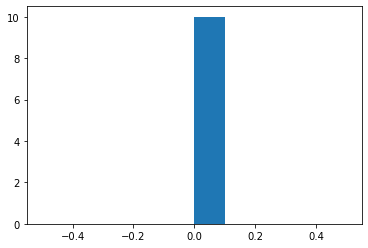

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.5742999911308289, crossentropy=1.3173576593399048)
Online Training Size/Num Samples/Trial: 0/10/1
torch.Size([10010, 10, 10])
tensor(0.) tensor(nan)


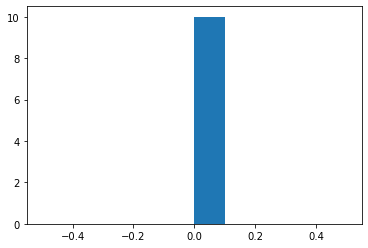

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.583299994468689, crossentropy=1.3814374208450317)
Online Training Size/Num Samples/Trial: 0/10/2
torch.Size([10010, 10, 10])
tensor(0.) tensor(nan)


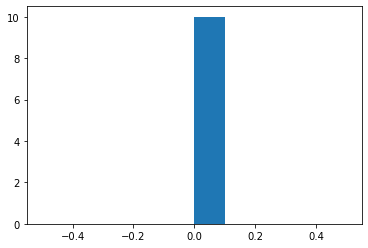

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.5658000111579895, crossentropy=1.4978936910629272)
Online Training Size/Num Samples/Trial: 0/10/3
torch.Size([10010, 10, 10])
tensor(0.) tensor(nan)


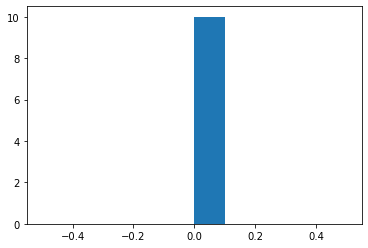

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=3, num_samples=10, accuracy=0.567799985408783, crossentropy=1.5471975803375244)
Online Training Size/Num Samples/Trial: 0/10/4
torch.Size([10010, 10, 10])
tensor(0.) tensor(nan)


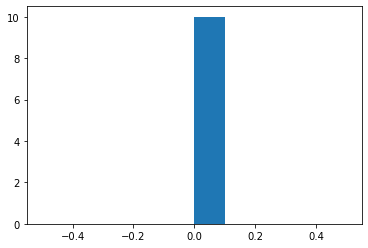

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=4, num_samples=10, accuracy=0.5877000093460083, crossentropy=1.3796792030334473)
Online Training Size/Num Samples/Trial: 0/100/0
torch.Size([10010, 100, 10])
tensor(0.) tensor(nan)


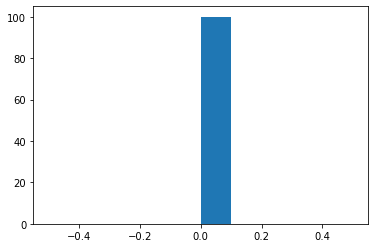

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=0, num_samples=100, accuracy=0.5849000215530396, crossentropy=1.3507739305496216)
Online Training Size/Num Samples/Trial: 0/100/1
torch.Size([10010, 100, 10])
tensor(0.) tensor(nan)


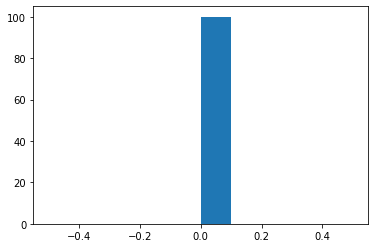

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=1, num_samples=100, accuracy=0.5927000045776367, crossentropy=1.3224592208862305)
Online Training Size/Num Samples/Trial: 0/100/2
torch.Size([10010, 100, 10])
tensor(0.) tensor(nan)


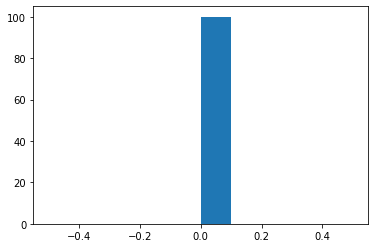

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=2, num_samples=100, accuracy=0.5928000211715698, crossentropy=1.334039330482483)
Online Training Size/Num Samples/Trial: 0/100/3
torch.Size([10010, 100, 10])
tensor(0.) tensor(nan)


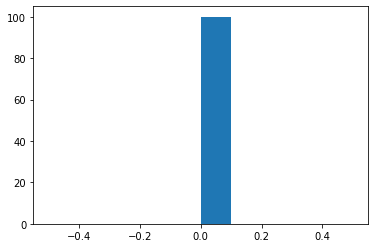

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=3, num_samples=100, accuracy=0.5871000289916992, crossentropy=1.3419795036315918)
Online Training Size/Num Samples/Trial: 0/100/4
torch.Size([10010, 100, 10])
tensor(0.) tensor(nan)


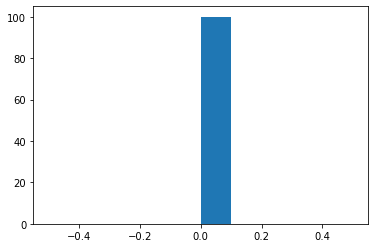

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=4, num_samples=100, accuracy=0.5874000191688538, crossentropy=1.3583260774612427)
Online Training Size/Num Samples/Trial: 1/10/0
torch.Size([10010, 10, 10])
tensor(-4.9288) tensor(-7.0426)


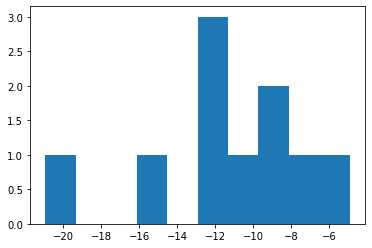

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=0, num_samples=10, accuracy=0.46799999475479126, crossentropy=1.6246726512908936)
Online Training Size/Num Samples/Trial: 1/10/1
torch.Size([10010, 10, 10])
tensor(-4.9288) tensor(-6.1348)


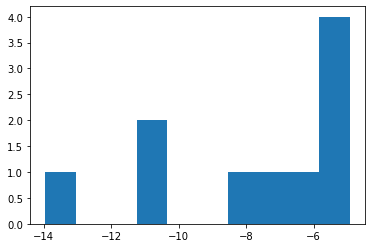

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=1, num_samples=10, accuracy=0.5939000248908997, crossentropy=1.3758227825164795)
Online Training Size/Num Samples/Trial: 1/10/2
torch.Size([10010, 10, 10])
tensor(-5.3695) tensor(-7.1130)


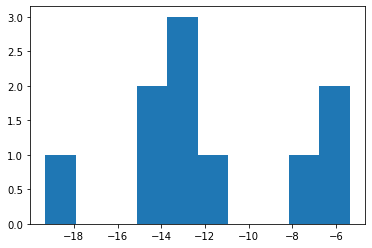

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=2, num_samples=10, accuracy=0.5620999932289124, crossentropy=1.5565084218978882)
Online Training Size/Num Samples/Trial: 1/10/3
torch.Size([10010, 10, 10])
tensor(-2.7579) tensor(-4.5900)


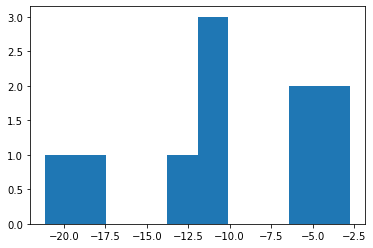

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=3, num_samples=10, accuracy=0.46779999136924744, crossentropy=1.5106593370437622)
Online Training Size/Num Samples/Trial: 1/10/4
torch.Size([10010, 10, 10])
tensor(-3.9723) tensor(-5.7635)


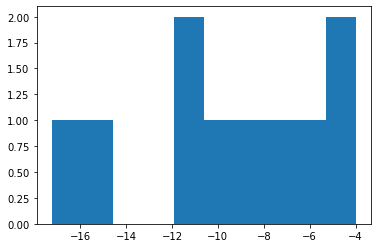

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=4, num_samples=10, accuracy=0.5723000168800354, crossentropy=1.34258234500885)
Online Training Size/Num Samples/Trial: 1/100/0
torch.Size([10010, 100, 10])
tensor(-2.8890) tensor(-5.3845)


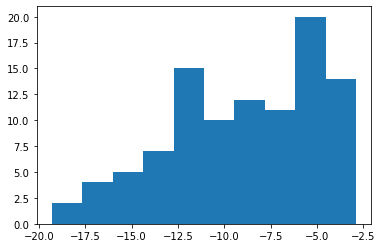

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=0, num_samples=100, accuracy=0.567799985408783, crossentropy=1.344135046005249)
Online Training Size/Num Samples/Trial: 1/100/1
torch.Size([10010, 100, 10])
tensor(-2.6725) tensor(-5.3252)


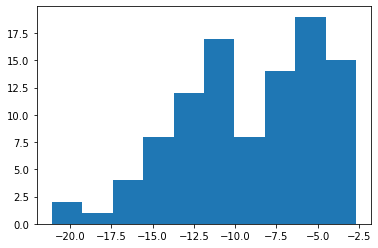

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=1, num_samples=100, accuracy=0.5565999746322632, crossentropy=1.3762857913970947)
Online Training Size/Num Samples/Trial: 1/100/2
torch.Size([10010, 100, 10])
tensor(-2.9441) tensor(-5.6520)


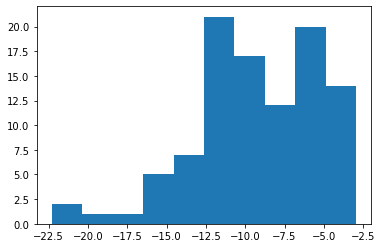

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=2, num_samples=100, accuracy=0.5745999813079834, crossentropy=1.3500847816467285)
Online Training Size/Num Samples/Trial: 1/100/3
torch.Size([10010, 100, 10])
tensor(-2.6725) tensor(-5.3949)


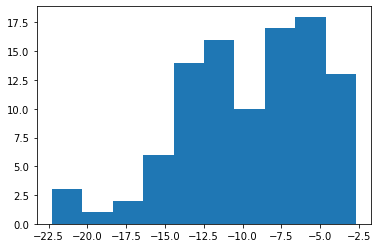

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=3, num_samples=100, accuracy=0.5565999746322632, crossentropy=1.366755723953247)
Online Training Size/Num Samples/Trial: 1/100/4
torch.Size([10010, 100, 10])
tensor(-2.8890) tensor(-5.5642)


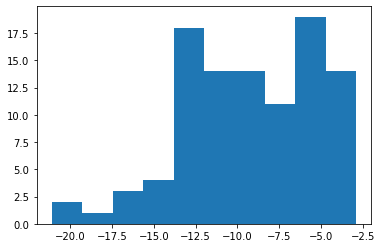

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=21, real_training_set_size=20, online_training_set_size=1, trial_index=4, num_samples=100, accuracy=0.5674999952316284, crossentropy=1.3576483726501465)
Online Training Size/Num Samples/Trial: 2/10/0
torch.Size([10010, 10, 10])
tensor(-7.1250) tensor(-4.5134)


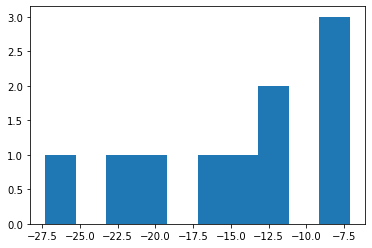

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=0, num_samples=10, accuracy=0.5209000110626221, crossentropy=1.431923747062683)
Online Training Size/Num Samples/Trial: 2/10/1
torch.Size([10010, 10, 10])
tensor(-6.8333) tensor(-4.4519)


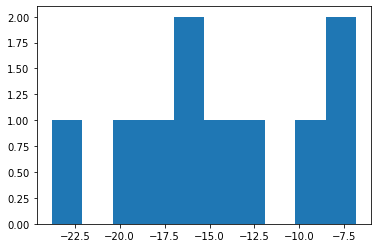

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=1, num_samples=10, accuracy=0.5680000185966492, crossentropy=1.355170488357544)
Online Training Size/Num Samples/Trial: 2/10/2
torch.Size([10010, 10, 10])
tensor(-4.6414) tensor(-3.4623)


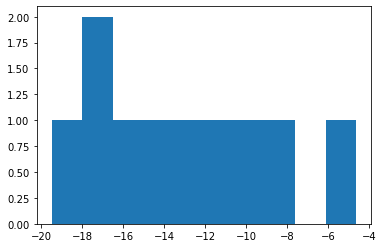

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=2, num_samples=10, accuracy=0.47369998693466187, crossentropy=1.7250007390975952)
Online Training Size/Num Samples/Trial: 2/10/3
torch.Size([10010, 10, 10])
tensor(-4.6414) tensor(-3.4626)


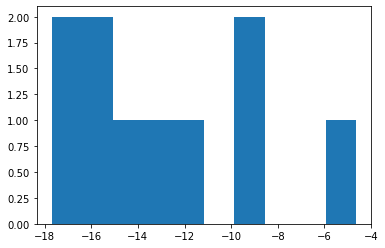

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=3, num_samples=10, accuracy=0.47189998626708984, crossentropy=1.698228120803833)
Online Training Size/Num Samples/Trial: 2/10/4
torch.Size([10010, 10, 10])
tensor(-6.8333) tensor(-4.5676)


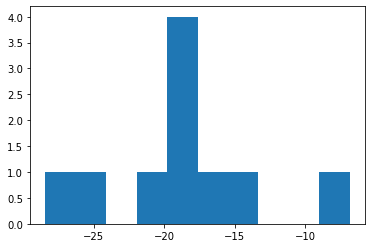

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=4, num_samples=10, accuracy=0.5217000246047974, crossentropy=1.4466438293457031)
Online Training Size/Num Samples/Trial: 2/100/0
torch.Size([10010, 100, 10])
tensor(-4.6414) tensor(-4.2016)


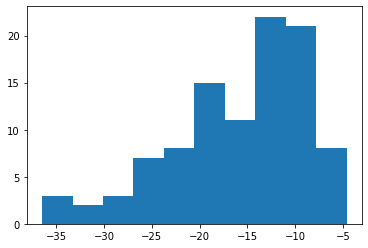

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=0, num_samples=100, accuracy=0.5285000205039978, crossentropy=1.4962666034698486)
Online Training Size/Num Samples/Trial: 2/100/1
torch.Size([10010, 100, 10])
tensor(-5.8447) tensor(-4.6384)


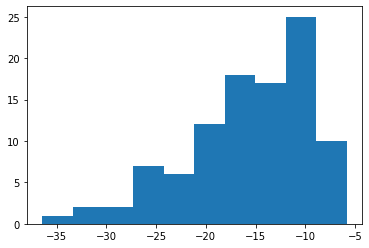

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=1, num_samples=100, accuracy=0.5464000105857849, crossentropy=1.4155572652816772)
Online Training Size/Num Samples/Trial: 2/100/2
torch.Size([10010, 100, 10])
tensor(-4.6414) tensor(-4.2244)


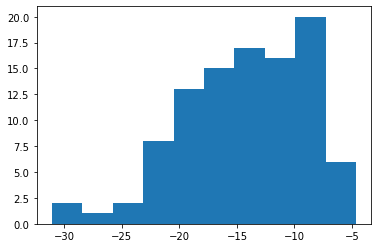

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=2, num_samples=100, accuracy=0.5364000201225281, crossentropy=1.4541970491409302)
Online Training Size/Num Samples/Trial: 2/100/3
torch.Size([10010, 100, 10])
tensor(-6.2287) tensor(-4.6844)


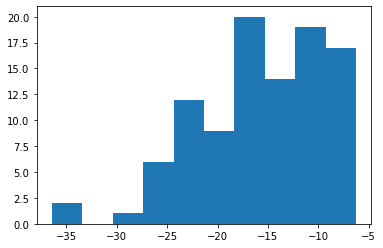

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=3, num_samples=100, accuracy=0.59170001745224, crossentropy=1.309928297996521)
Online Training Size/Num Samples/Trial: 2/100/4
torch.Size([10010, 100, 10])
tensor(-6.2287) tensor(-4.7685)


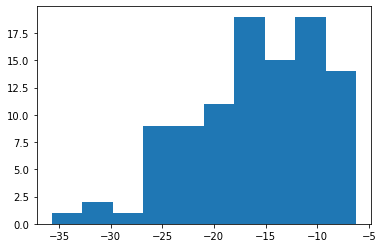

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=22, real_training_set_size=20, online_training_set_size=2, trial_index=4, num_samples=100, accuracy=0.5859000086784363, crossentropy=1.3602101802825928)
Online Training Size/Num Samples/Trial: 3/10/0
torch.Size([10010, 10, 10])
tensor(-13.3996) tensor(-5.2085)


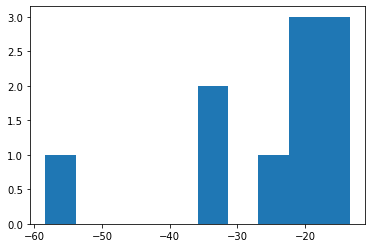

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=0, num_samples=10, accuracy=0.48890000581741333, crossentropy=1.5711921453475952)
Online Training Size/Num Samples/Trial: 3/10/1
torch.Size([10010, 10, 10])
tensor(-13.1385) tensor(-5.0664)


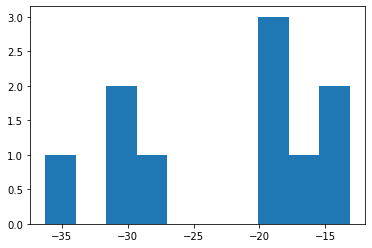

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=1, num_samples=10, accuracy=0.535099983215332, crossentropy=1.5120761394500732)
Online Training Size/Num Samples/Trial: 3/10/2
torch.Size([10010, 10, 10])
tensor(-11.6424) tensor(-4.5786)


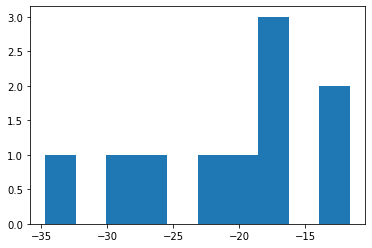

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=2, num_samples=10, accuracy=0.5216000080108643, crossentropy=1.4761110544204712)
Online Training Size/Num Samples/Trial: 3/10/3
torch.Size([10010, 10, 10])
tensor(-9.9009) tensor(-4.0495)


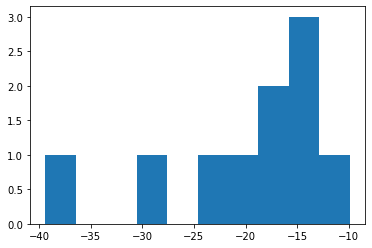

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=3, num_samples=10, accuracy=0.5318999886512756, crossentropy=1.4289307594299316)
Online Training Size/Num Samples/Trial: 3/10/4
torch.Size([10010, 10, 10])
tensor(-13.8211) tensor(-5.3309)


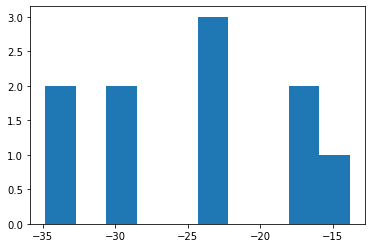

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=4, num_samples=10, accuracy=0.4945000112056732, crossentropy=1.483237385749817)
Online Training Size/Num Samples/Trial: 3/100/0
torch.Size([10010, 100, 10])
tensor(-11.6864) tensor(-5.0547)


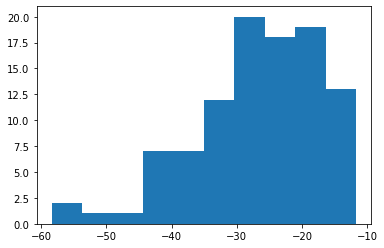

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=0, num_samples=100, accuracy=0.5623000264167786, crossentropy=1.4142738580703735)
Online Training Size/Num Samples/Trial: 3/100/1
torch.Size([10010, 100, 10])
tensor(-9.5508) tensor(-4.4403)


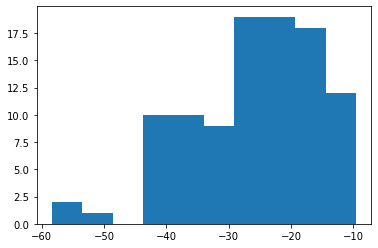

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=1, num_samples=100, accuracy=0.5422000288963318, crossentropy=1.3815956115722656)
Online Training Size/Num Samples/Trial: 3/100/2
torch.Size([10010, 100, 10])
tensor(-9.5508) tensor(-4.5878)


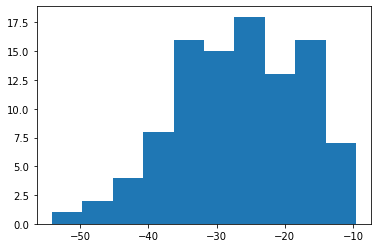

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=2, num_samples=100, accuracy=0.49470001459121704, crossentropy=1.5541729927062988)
Online Training Size/Num Samples/Trial: 3/100/3
torch.Size([10010, 100, 10])
tensor(-9.5508) tensor(-4.4842)


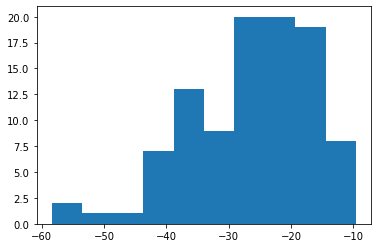

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=3, num_samples=100, accuracy=0.5351999998092651, crossentropy=1.3899881839752197)
Online Training Size/Num Samples/Trial: 3/100/4
torch.Size([10010, 100, 10])
tensor(-11.6424) tensor(-5.0463)


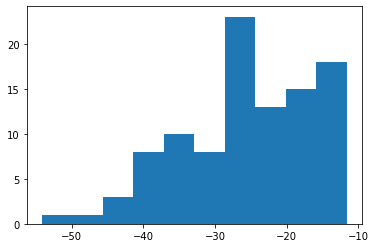

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=23, real_training_set_size=20, online_training_set_size=3, trial_index=4, num_samples=100, accuracy=0.5907999873161316, crossentropy=1.359989047050476)
Online Training Size/Num Samples/Trial: 4/10/0
torch.Size([10010, 10, 10])
tensor(-13.5190) tensor(-3.7982)


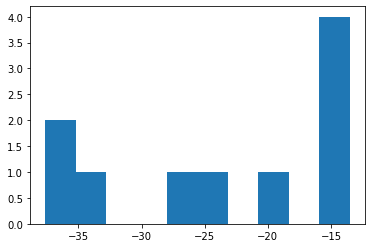

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=0, num_samples=10, accuracy=0.5406000018119812, crossentropy=1.450213074684143)
Online Training Size/Num Samples/Trial: 4/10/1
torch.Size([10010, 10, 10])
tensor(-26.5494) tensor(-7.1497)


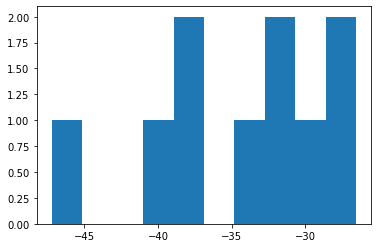

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=1, num_samples=10, accuracy=0.5472999811172485, crossentropy=1.6037453413009644)
Online Training Size/Num Samples/Trial: 4/10/2
torch.Size([10010, 10, 10])
tensor(-16.2201) tensor(-4.6200)


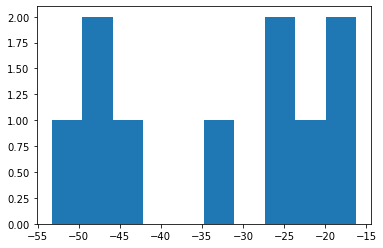

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=2, num_samples=10, accuracy=0.5299000144004822, crossentropy=1.4628994464874268)
Online Training Size/Num Samples/Trial: 4/10/3
torch.Size([10010, 10, 10])
tensor(-16.8467) tensor(-4.5920)


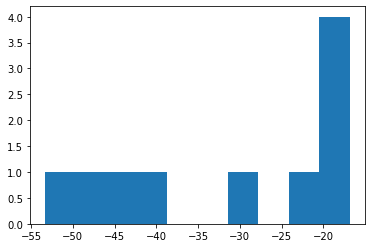

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=3, num_samples=10, accuracy=0.5482000112533569, crossentropy=1.3900562524795532)
Online Training Size/Num Samples/Trial: 4/10/4
torch.Size([10010, 10, 10])
tensor(-19.5328) tensor(-5.2932)


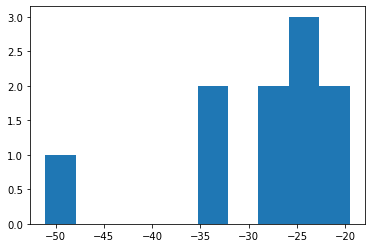

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=4, num_samples=10, accuracy=0.5390999913215637, crossentropy=1.5897239446640015)
Online Training Size/Num Samples/Trial: 4/100/0
torch.Size([10010, 100, 10])
tensor(-13.3519) tensor(-4.2822)


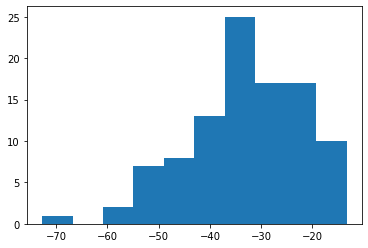

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=0, num_samples=100, accuracy=0.5924999713897705, crossentropy=1.3244596719741821)
Online Training Size/Num Samples/Trial: 4/100/1
torch.Size([10010, 100, 10])
tensor(-14.2322) tensor(-4.5165)


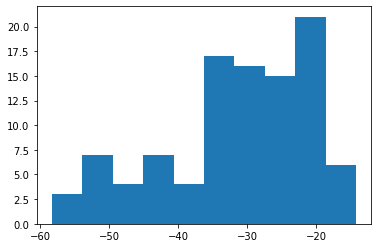

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=1, num_samples=100, accuracy=0.5213000178337097, crossentropy=1.4956024885177612)
Online Training Size/Num Samples/Trial: 4/100/2
torch.Size([10010, 100, 10])
tensor(-13.6180) tensor(-4.3872)


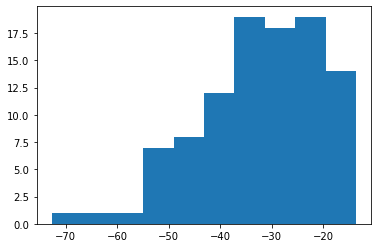

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=2, num_samples=100, accuracy=0.5652999877929688, crossentropy=1.361990213394165)
Online Training Size/Num Samples/Trial: 4/100/3
torch.Size([10010, 100, 10])
tensor(-13.3519) tensor(-4.2979)


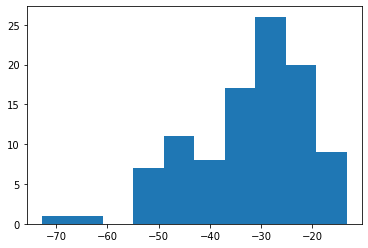

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=3, num_samples=100, accuracy=0.5892000198364258, crossentropy=1.3231515884399414)
Online Training Size/Num Samples/Trial: 4/100/4
torch.Size([10010, 100, 10])
tensor(-13.3519) tensor(-4.3771)


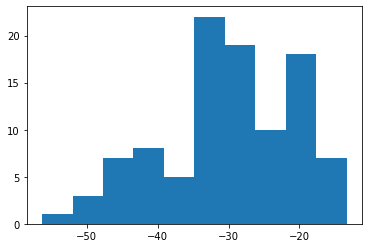

torch.Size([10000, 100, 10])
OBIPerformance(total_training_set_size=24, real_training_set_size=20, online_training_set_size=4, trial_index=4, num_samples=100, accuracy=0.5616999864578247, crossentropy=1.3872970342636108)
Online Training Size/Num Samples/Trial: 5/10/0
torch.Size([10010, 10, 10])
tensor(-19.8283) tensor(-4.4254)


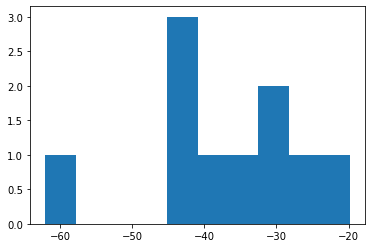

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=25, real_training_set_size=20, online_training_set_size=5, trial_index=0, num_samples=10, accuracy=0.38850000500679016, crossentropy=1.8228973150253296)
Online Training Size/Num Samples/Trial: 5/10/1
torch.Size([10010, 10, 10])
tensor(-23.3211) tensor(-5.1166)


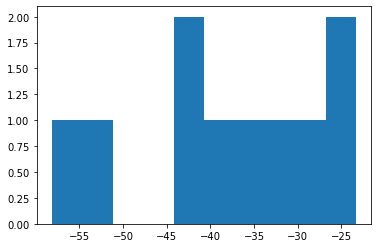

torch.Size([10000, 10, 10])
OBIPerformance(total_training_set_size=25, real_training_set_size=20, online_training_set_size=5, trial_index=1, num_samples=10, accuracy=0.4708000123500824, crossentropy=1.6987605094909668)
Online Training Size/Num Samples/Trial: 5/10/2
torch.Size([10010, 10, 10])
tensor(-22.9463) tensor(-4.9228)


KeyboardInterrupt: 

In [ ]:
# experiment

experiment = Experiment(seed=1120, num_pool_samples=100, device="cuda", num_samples_list=(10, 100))

results = {}
experiment.run(results)

In [ ]:
results

{'initial_training_set_indices': [51348,
  49110,
  8222,
  28130,
  13484,
  47685,
  3938,
  59930,
  49196,
  19427,
  4601,
  49922,
  45635,
  35684,
  3579,
  7621,
  8465,
  33959,
  27521,
  27015],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'obi_performances': [[OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.538100004196167, crossentropy=1.516221893453387),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.5690000057220459, crossentropy=1.394369463295061),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.578000009059906, crossentropy=1.4390312500523),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_s

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
    )
    for seed in range(1)
    for acquisition_size in [5]
    for num_pool_samples in [100]
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

1

In [ ]:
# slow
import prettyprinter

prettyprinter.install_extras(include={"dataclasses"})

prettyprinter.pprint(configs)

[Experiment(seed=0, num_pool_samples=100)]



accuracy,▁▂▇█
crossentropy,▅█▃▁
model_training/best_epoch,▁▂▆█
model_training/best_val_accuracy,▁▂▆█
model_training/best_val_crossentropy,▅█▅▁
accuracy,0.7008
crossentropy,1.12005
model_training/best_epoch,46
model_training/best_val_accuracy,0.69922
model_training/best_val_crossentropy,1.07317
